In [13]:
%load_ext autoreload
%autoreload 2
# importing the libraries and files

import math
from collections import Counter
from functools import reduce
import ast
import numpy as np

import geopandas as gpd
import networkx as nx
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.interpolate import interp1d
import seaborn as sns
#from statsmodels.stats import diagnostic

from src.data.utils import get_franchise_movies, get_franchise_data

# setting the color theme for the plots
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# loading the completed dataset
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')

# keeping only movies in franchises
franchise_df = get_franchise_movies(movies_df)

### Basic numerical analysis

In [16]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")

count    1595.000000
mean        3.243260
std         3.751337
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5173


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 

Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).

### Basic visualization

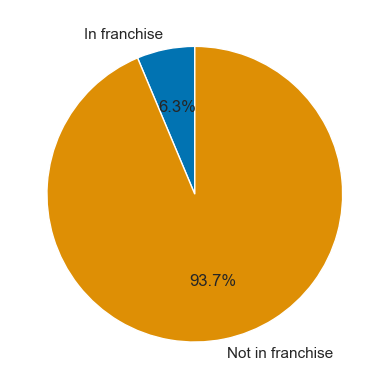

In [17]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

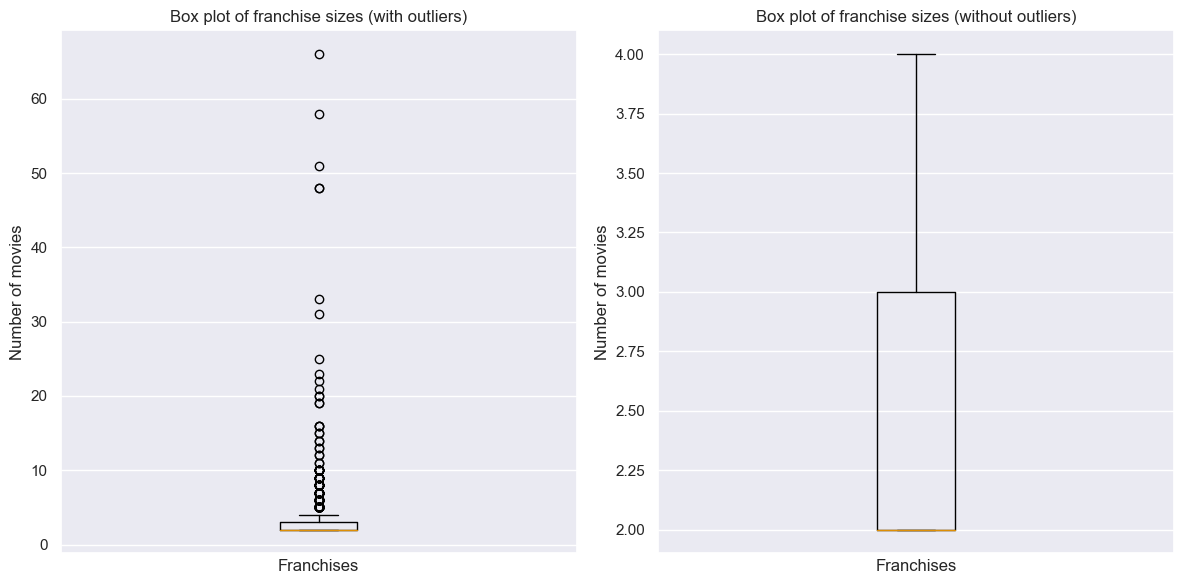

In [18]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

### Focusing on genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies.

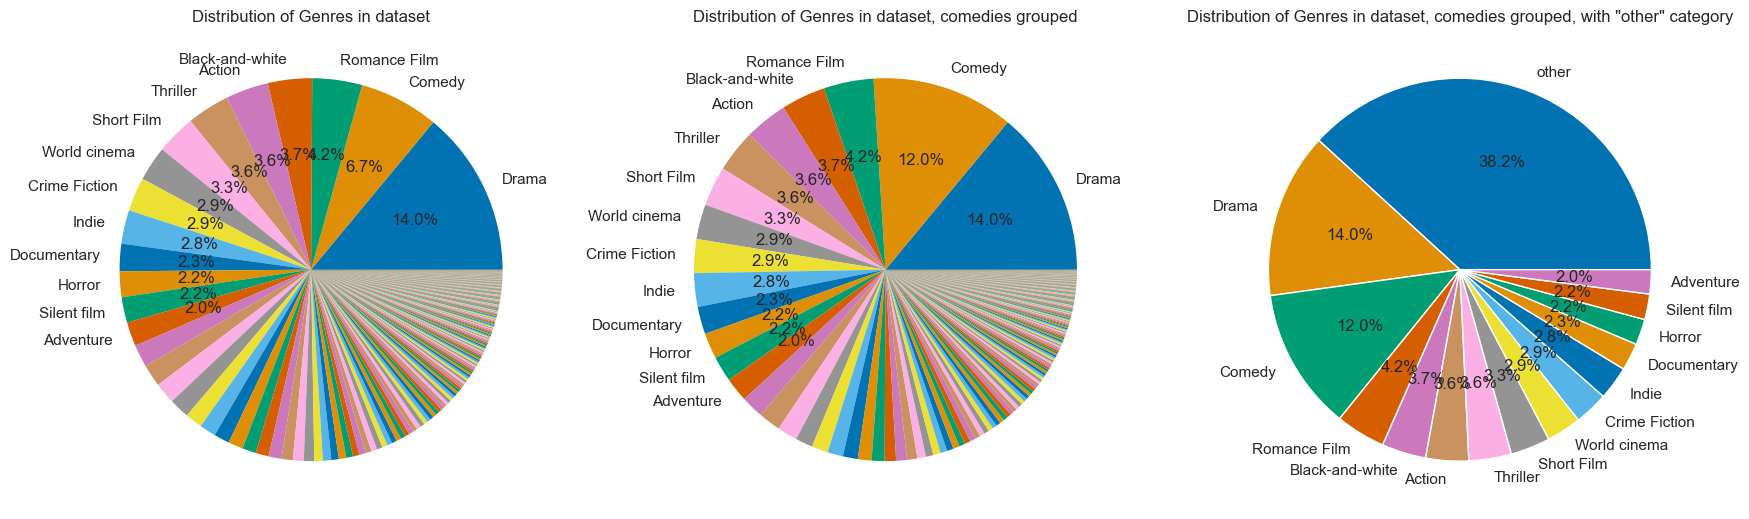

In [19]:
genre_counts = Counter()

for genres in movies_df['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip().replace("}", "") for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','')
genre_counts_df = genre_counts_df.sort_values(by='counts', ascending=False)
# Clean up genre names by removing double quotes
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace('"', '')

# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

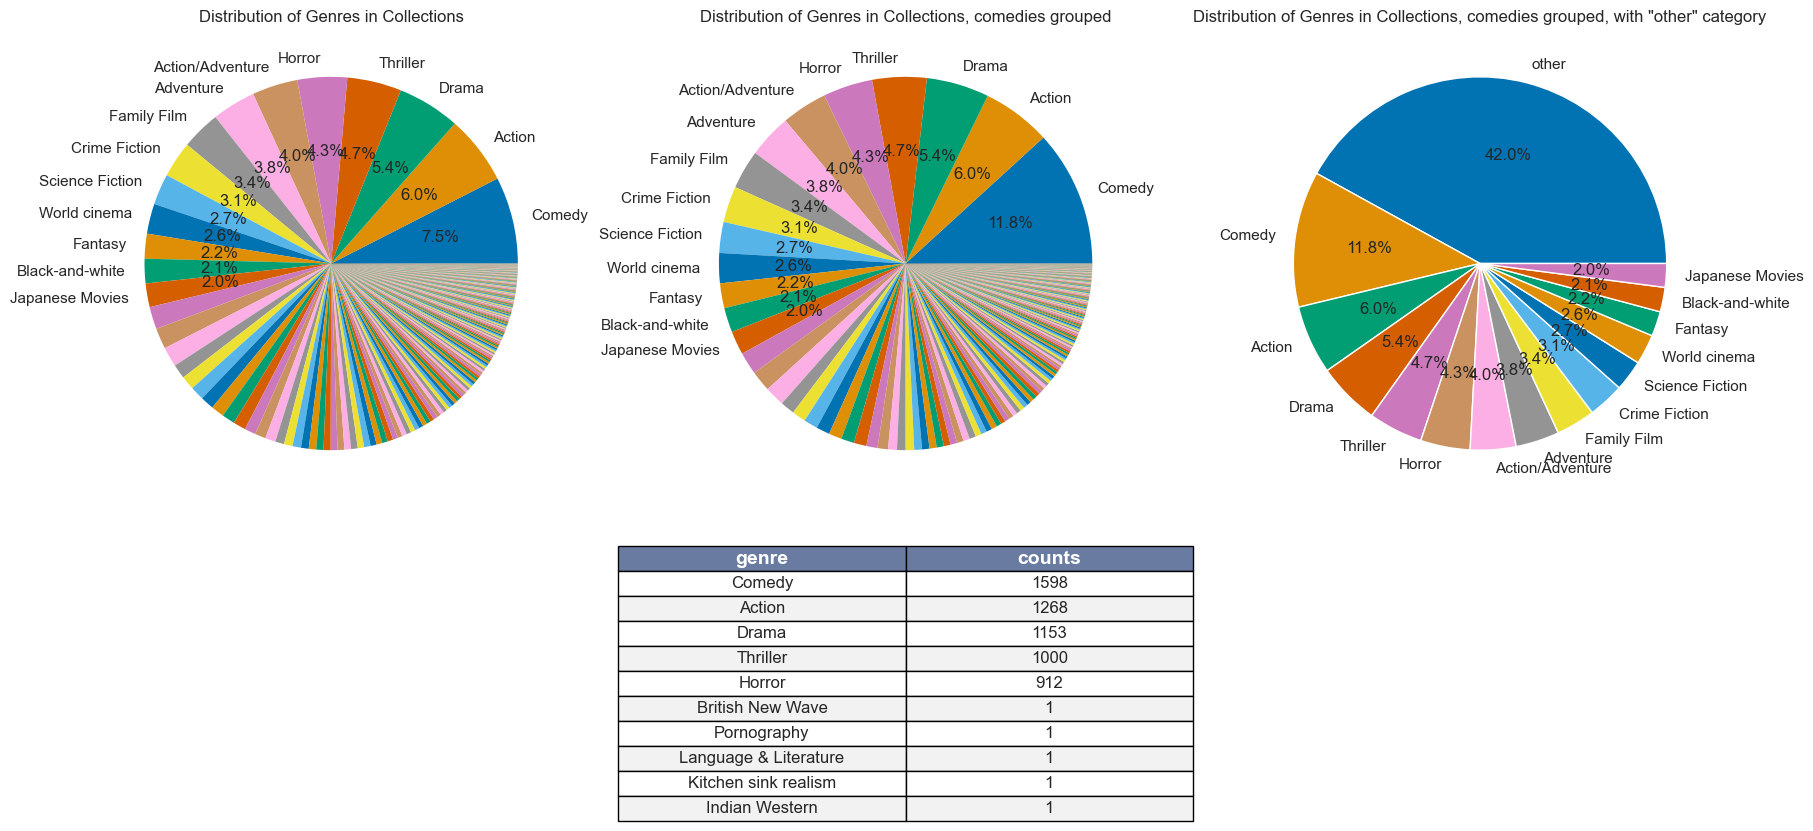

In [20]:
genre_counts = Counter()

for genres in franchise_df['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip().replace("}", "") for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','')
genre_counts_df = genre_counts_df.sort_values(by='counts', ascending=False)
# Clean up genre names by removing double quotes
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace('"', '')

# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

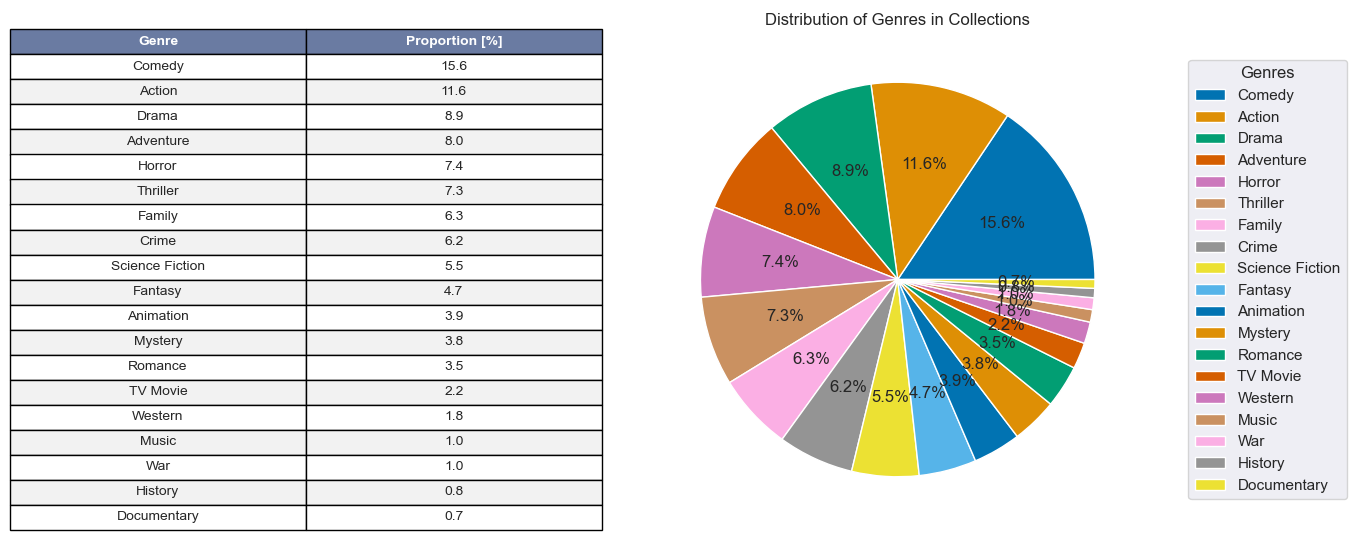

In [21]:
# Function to extract genre names from the string representation of the list of dictionaries
def extract_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list]
    except (ValueError, SyntaxError):
        return []

# Apply the function to the 'genres' column
franchise_df.loc[:, 'cleaned_genres'] = franchise_df['genres'].apply(extract_genres)

# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['cleaned_genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

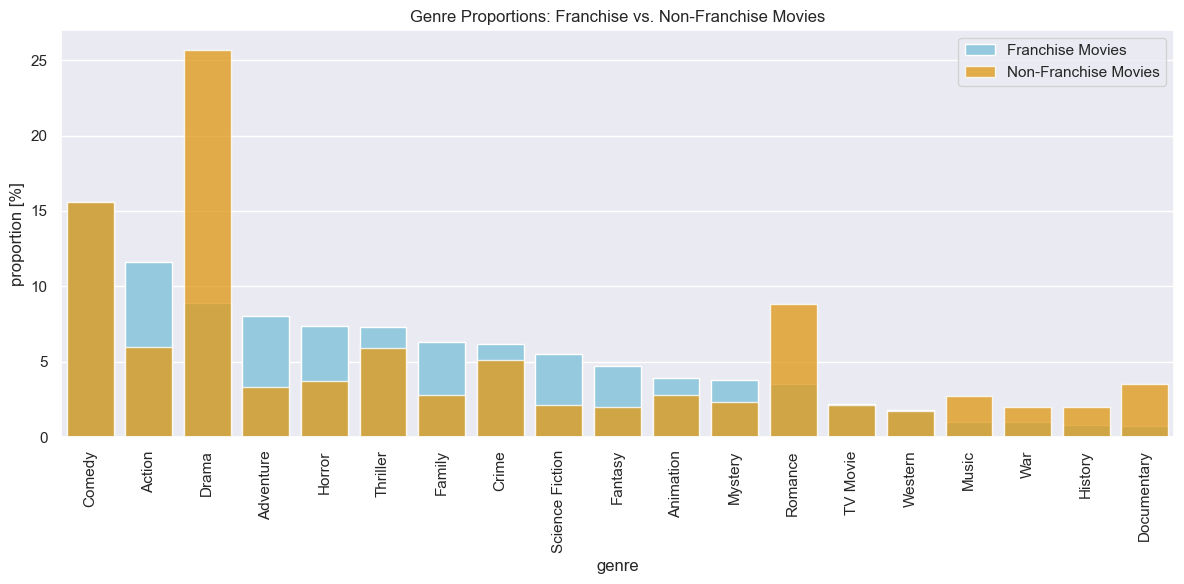

In [22]:
# Extract movies not in franchise
non_franchise_df = movies_df[~movies_df['Wikipedia movie ID'].isin(franchise_df['Wikipedia movie ID'])].copy()

# Extract genres proportions for movies not in franchise, as done before
non_franchise_df.loc[:, 'cleaned_genres'] = non_franchise_df['genres'].apply(extract_genres)
nf_flattened_genres = [genre for sublist in non_franchise_df['cleaned_genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()


Here, we can see that Dramas are a lot more present (three times more) in non-franchise movies than in franchise movies. Why is that ? Do the viewers lose interest when they are presented multiple dramas in a row ? If so, how would that translate ? In worse ratings ? Less box-office revenues ? Let's dive deeper into these questions, and try to understand the disparities between franchise and non-franchise movies, as well as understanding what makes a saga successful.

now, we know this genre more represented, blabla, but is there a reason ? do they perform better ? attention à la normalisation !!
actual dramas and romance and ones that are less present in franchise, look at success and look at:
- if they are successful, are they often paired ? because we need to explain why they are so under-represented
- if they are not successful, end of analysis

### Box office analysis 

In [23]:
franchise_df = franchise_df.dropna(subset=['Movie box office revenue'])
movies_df = movies_df.dropna(subset=['Movie box office revenue'])
print(franchise_df['collection_id'].value_counts())

collection_id
645.0       22
9735.0      11
1241.0       8
656.0        7
534673.0     7
            ..
168186.0     1
745296.0     1
94589.0      1
99606.0      1
166379.0     1
Name: count, Length: 667, dtype: int64


If we clean the data set toward the box office datas, of the franchise movies (erease missing values), one can see that some franchise does not have this value for all its movies. 

In [24]:
movies_no_franchise = movies_df.copy()[movies_df['collection_id'].isna()]
#movie_box = data_no_coll.dropna(subset=['Movie box office revenue'])
print(movies_no_franchise['Movie box office revenue'].describe())


count    6.929000e+03
mean     3.124319e+07
std      6.867860e+07
min      1.000000e+04
25%      1.750000e+06
50%      7.706368e+06
75%      2.886208e+07
max      2.185372e+09
Name: Movie box office revenue, dtype: float64


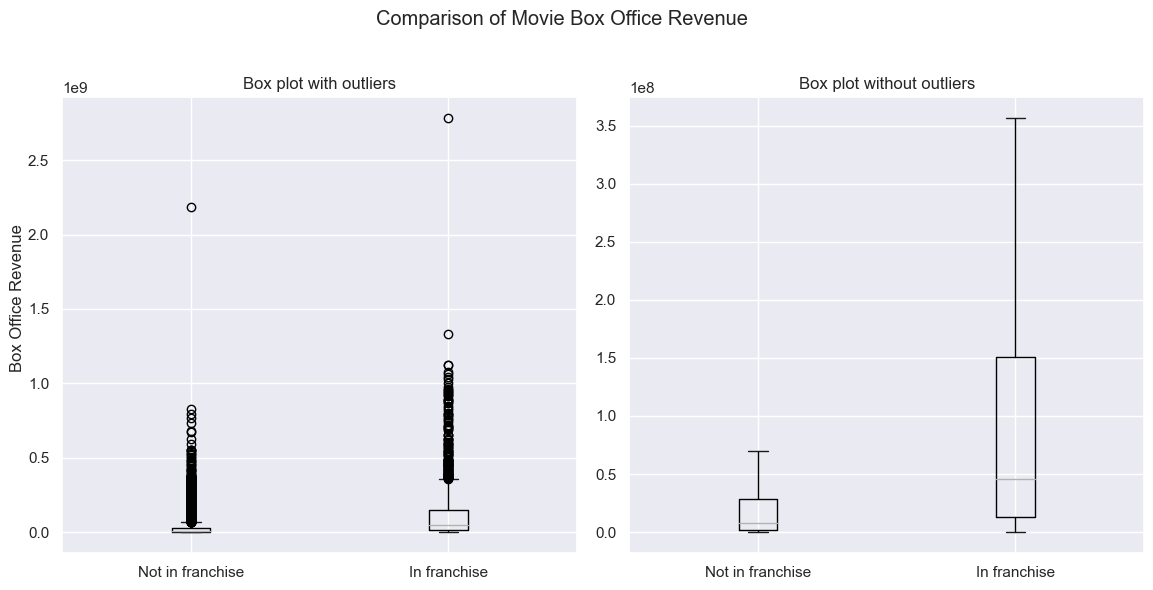

In [25]:
all_box= pd.DataFrame({
        'Not in franchise': movies_no_franchise['Movie box office revenue'], #movie_box['Movie box office revenue'],
        'In franchise': franchise_df['Movie box office revenue'] # box_office_df['Movie box office revenue']
        })

#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_box.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_box.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()



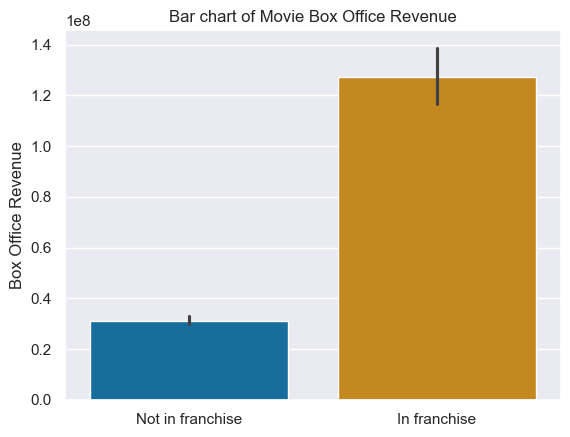

In [26]:
ax = sns.barplot(data=all_box)
plt.title('Bar chart of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

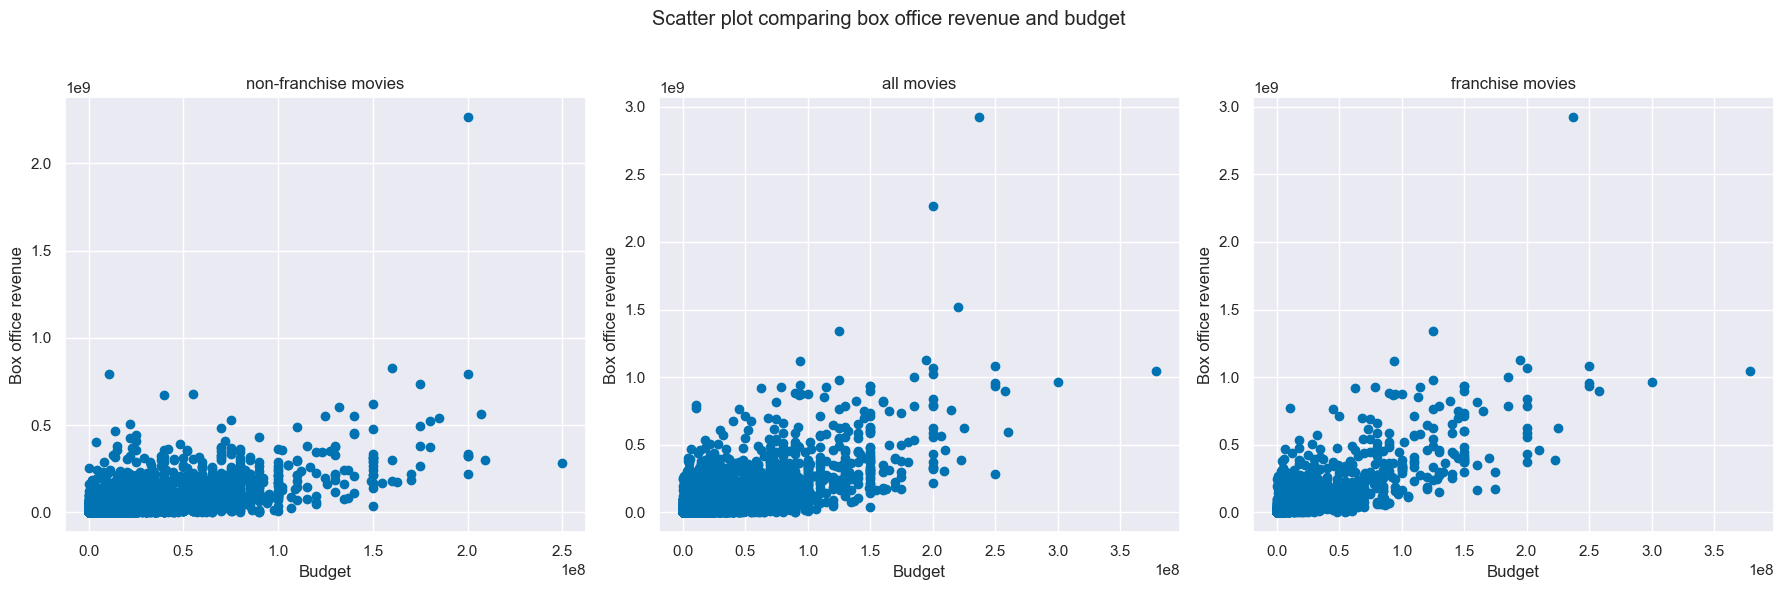

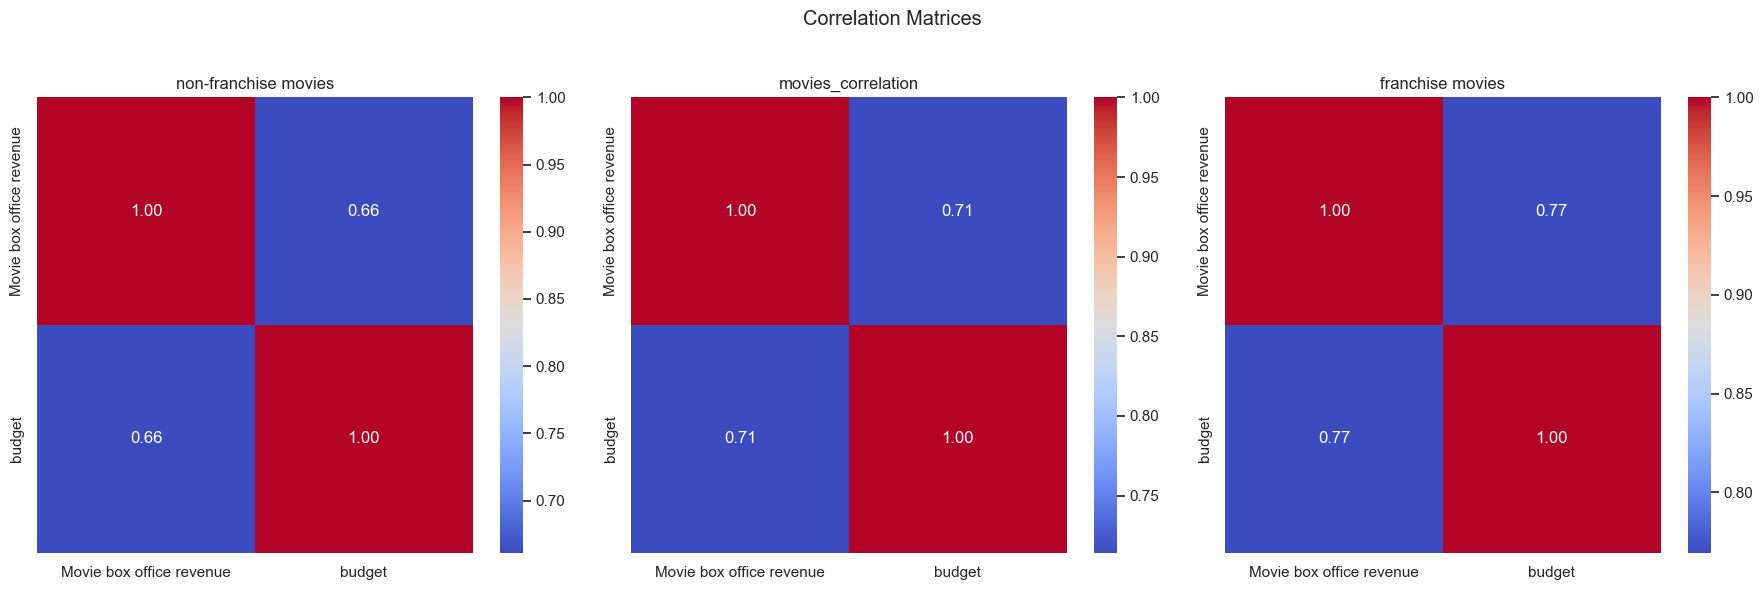

In [50]:
#Formating the box office and budget values 
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Plot the correlation matrix 
ax1.scatter(movies_no_franchise['budget'], movies_no_franchise['revenue'])
ax1.set_title("non-franchise movies")
ax1.set_xlabel('Budget')
ax1.set_ylabel('Box office revenue')

ax2.scatter(movies_df['budget'], movies_df['revenue'])
ax2.set_title("all movies")
ax2.set_xlabel('Budget')
ax2.set_ylabel('Box office revenue')

ax3.scatter(franchise_df['budget'], franchise_df['revenue'])
ax3.set_title("franchise movies")
ax3.set_xlabel('Budget')
ax3.set_ylabel('Box office revenue')

fig.suptitle('Scatter plot comparing box office revenue and budget ')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

def correlation_revenue_budget(df):
    # Calculate the correlation between 'budget' and 'revenue'
    numerical_df = df.select_dtypes(include='number').drop(columns=['ratio_box_budget','Freebase movie ID','Movie name','Movie release date','vote_count','release_year','run_time','nbr_movie_per_col','movie_order','tmdb_id','cote_count','vote_average','Movie runtime','Wikipedia movie ID','collection_name',	'collection_id','revenue'], errors='ignore')
    correlation_matrix = numerical_df.corr()
    return correlation_matrix

non_franchise_correlation=correlation_revenue_budget(movies_no_franchise)
movies_correlation=correlation_revenue_budget(movies_df)
franchise_correlation=correlation_revenue_budget(franchise_df)

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Plot the correlation matrix 
sns.heatmap(non_franchise_correlation, annot=True, cmap="coolwarm", fmt=".2f", ax=ax1)
ax1.set_title("non-franchise movies")

sns.heatmap(movies_correlation, annot=True, cmap="coolwarm", fmt=".2f", ax=ax2)
ax2.set_title("movies_correlation")

sns.heatmap(franchise_correlation, annot=True, cmap="coolwarm", fmt=".2f", ax=ax3)
ax3.set_title("franchise movies")

fig.suptitle('Correlation Matrices')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


There is a linear positive correlation between box office revenue and budget that increase in franchise movies. 

In [43]:
#Formating the date in all the data set 
franchise_df['Movie release date corrected'] = pd.to_datetime(franchise_df['Movie release date'],format='mixed',yearfirst=True)
franchise_df['release_year'] = franchise_df['Movie release date corrected'].dt.year
movies_df['Movie release date'] = pd.to_datetime(movies_df['Movie release date'], errors='coerce')
movies_df['release_year'] = movies_df['Movie release date'].dt.year

franchise_df['movie_order']=franchise_df.groupby('collection_id')['release_year'].rank(ascending=True)
#cleaning the data 
franchise_df['release_year'].dropna()

#Formating the box office and budget values 
def scientific_notation(x):
    return "{:.2e}".format(x)

franchise_df['budget'] = pd.to_numeric(franchise_df['budget'])
franchise_df['Movie box office revenue'] = pd.to_numeric(franchise_df['Movie box office revenue'])
#franchise_df['budget'] = franchise_df['budget'].apply(scientific_notation)
#franchise_df['Movie box office revenue']= franchise_df['Movie box office revenue'].apply(scientific_notation)


In [44]:
def collection_budget_box_1(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    df = df.sort_values(by='release_year')

    # Plot budget 
    for index, row in df.iterrows():
        ax1.plot(row['release_year'], row['budget'], marker='o',linestyle='-',label=row['Movie name'])

    f_budget = interp1d(df['release_year'], df['budget'], kind='linear')
    x_budget = np.linspace(df['release_year'].min(), df['release_year'].max(), 500)
    y_budget = f_budget(x_budget)
    ax1.plot(x_budget, y_budget, '-', label='Interpolated Budget')
    ax1.set_ylabel('Budget')
    ax1.set_xlabel('Release Year')
    ax1.set_title('Budget over Time')

    # Plot box office revenue 
    for index, row in df.iterrows():
        ax2.plot(row['release_year'], row['Movie box office revenue'], marker='o', linestyle='-',label=row['Movie name'])
    
    f_revenue = interp1d(df['release_year'], df['Movie box office revenue'], kind='linear')
    x_revenue = np.linspace(df['release_year'].min(), df['release_year'].max(), 500)
    y_revenue = f_revenue(x_revenue)
    ax2.set_ylabel('Box Office Revenue')
    ax2.plot(x_revenue, y_revenue, '-', label='Interpolated Revenue')
    ax2.set_xlabel('Release Year')
    ax2.set_title('Box Office Revenue over Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the main title for the figure
    fig.suptitle(f"{df['collection_name'].iloc[0]}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


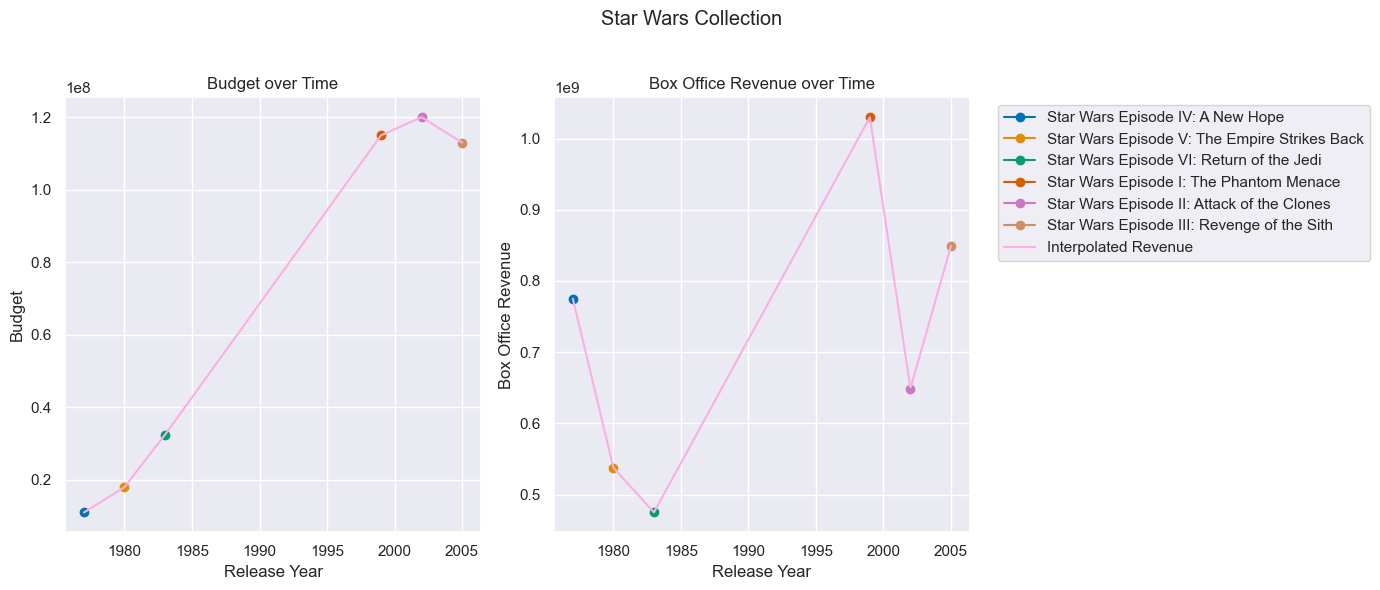

In [45]:
filtered_df = franchise_df[franchise_df['collection_id'] == 10]
collection_budget_box_1(filtered_df)


Here we plot the evolution through time of revenu and budget of movies in the franchise Star Wars. The goal is to create an interactive plot where you can choose the collection. 
Plus, to create an other interactive plot with the same information but as bar chart to be more readable. 


In [64]:
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
#conda install -c plotly plotly=5.24.1 

app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(
        id="dropdown",
        options=[{'label': name, 'value': name} for name in franchise_df['collection_name'].unique()],
        value='Star Wars Collection',
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def collection_budget_box(collection_name):
    df = franchise_df[franchise_df['collection_name'] == collection_name]

    fig = px.scatter(df, x='budget', y='revenue', text='movie_order' ,title=f"{df['collection_name'].iloc[0]}")
    fig.update_traces(marker=dict(size=10), selector=dict(mode='markers+text'),textposition='top right')

    fig.update_layout(
        xaxis_title='Budget',
        yaxis_title='Box Office Revenue',
        legend_title_text='Movie Name',
        legend=dict(x=1.05, y=1, traceorder='normal')
    )
    return fig

app.run_server(debug=True)


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



### Year Repartition (from the release date colomn)

#### initialisation for the year partition part

In [65]:
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')
movies_df['Movie release date corrected'] = pd.to_datetime(movies_df['Movie release date'], format='mixed', yearfirst=True, errors='coerce')
movies_df['release_year'] = movies_df['Movie release date corrected'].dt.year


franchise_df=get_franchise_movies(movies_df)
franchise_data_df = get_franchise_data(franchise_df)

In this section, we visualize the distribution of movies over the years to compare whether the CMU dataset and the franchise dataset contain a similar distribution of movies across time.

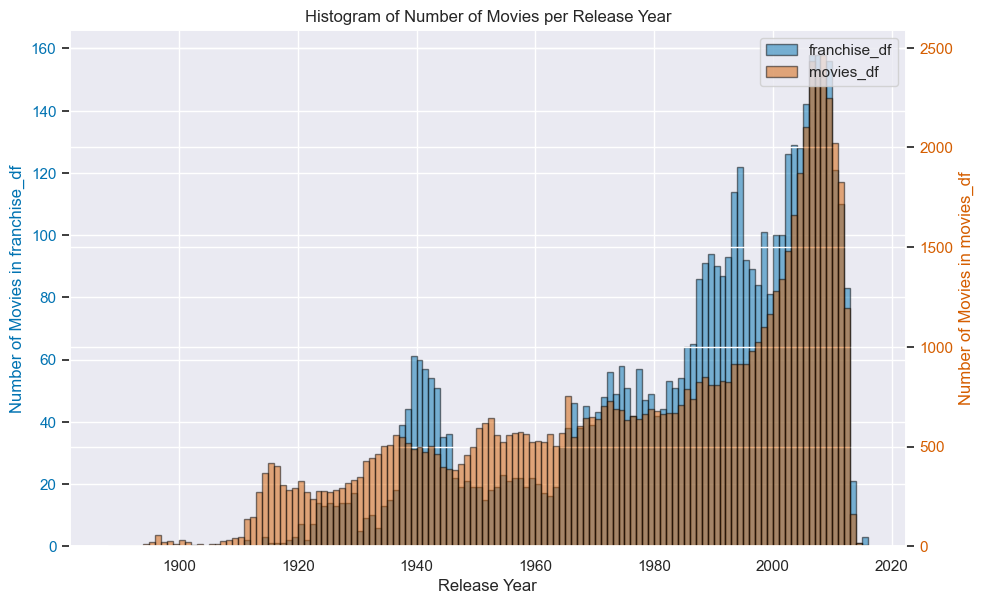

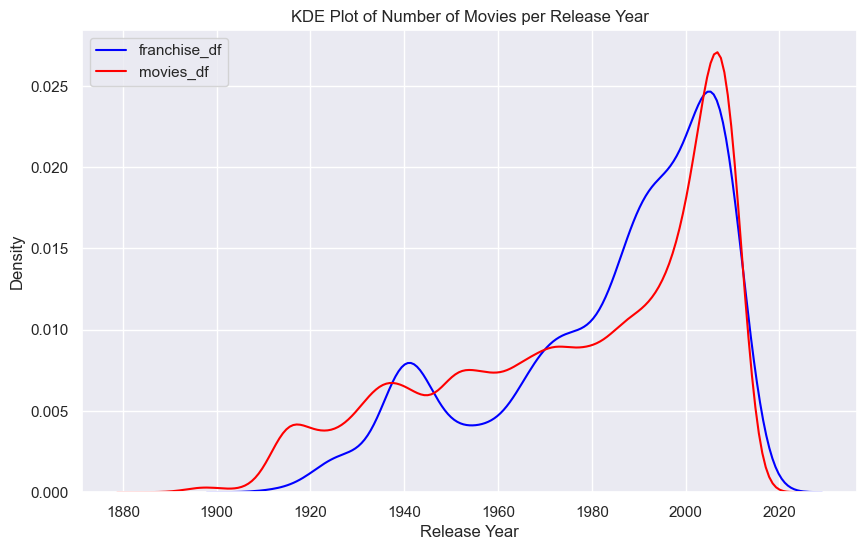

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the histogram for franchise_df
ax1.hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies in franchise_df', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax1.twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax, label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax, label='movies_df', color='red')

# Set labels and title
ax.set_xlabel('Release Year')
ax.set_ylabel('Density')
ax.set_title('KDE Plot of Number of Movies per Release Year')
ax.legend()

plt.show()

In this part, we're visualising in more detail the franchise and collections of movies we're working with

In [67]:
# Ensure the DataFrame is sorted by oldest_release for a neat plot
franchise_data_df = franchise_data_df.sort_values(by='franchise_length').reset_index(drop=True)

# Drop rows where oldest_release or newest_release is NaT (missing dates)
franchise_data_df = franchise_data_df.dropna(subset=['oldest_release', 'newest_release'])

# Define a color mapping for regions or countries
region_color_map = {
    'North America': 'blue',
    'Europe': 'green',
    'Asia': 'red',
    'Oceania': 'purple',
    'South America': 'orange',
    'Africa': 'brown',
    'Russia': 'pink',
    'Other': 'gray',
}
# Function to get the color for the first region
def get_first_region_color(regions):
    # Split regions into a list and pick the first one
    first_region = regions.split(', ')[0] if regions else 'Unknown'
    # Get the color for the region or a default color for unknown
    return region_color_map.get(first_region, 'gray')

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a bar chart figure
def create_figure(filtered_df):
    # Map each country to a color
    filtered_df['color'] = filtered_df['region'].apply(get_first_region_color)  # Default to gray if no mapping

    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            x=filtered_df['franchise_length'].apply(lambda x: pd.Timedelta(days=x).days / 365),  # Franchise lengths in years
            y=filtered_df['collection_name'],  # Franchise names
            orientation='h',
            base=filtered_df['oldest_release'].dt.year,  # Base of the bar is the oldest release date
            text=[
                f"Franchise: {row['collection_name']}<br>"
                f"Start Date: {row['oldest_release'].date()}<br>"
                f"End Date: {row['newest_release'].date()}<br>"
                f"Movies: {row['movie_count']}<br>"
                f"Revenue: ${row['revenue'] if not pd.isna(row['revenue']) else 'N/A'}<br>"
                f"Country: {row['country']}"
                for _, row in filtered_df.iterrows()
            ],  # Tooltip content
            hoverinfo="text",  # Use text for hover information
            marker=dict(color=filtered_df['color']),  # Use the color for the bars
        )
    )

    # Customize layout
    fig.update_layout(
        title="Franchise Durations",
        xaxis_title="Years",
        yaxis_title="Franchise",
        xaxis=dict(showgrid=True),
        yaxis=dict(showticklabels=False, showgrid=False),
        height=800,
        template="plotly_white",
    )
    return fig

# Define the layout of the app
app.layout = html.Div([
    html.H1("Franchise Duration Filter"),
    
    # Dropdown for filtering by revenue
    dcc.Dropdown(
        id='revenue-filter',
        options=[
            {'label': f'Revenue > ${threshold:,.0f}', 'value': threshold}
            for threshold in [0, 100_000_000, 500_000_000, 1_000_000_000]
        ],
        value=0,  # Default value (show all)
        style={'width': '50%'}
    ),
    
    

    # Graph for the bar chart
    dcc.Graph(id='franchise-graph')
])

# Define the callback to update the figure based on the filter
@app.callback(
    Output('franchise-graph', 'figure'),
    [Input('revenue-filter', 'value')]
)
def update_figure(selected_revenue):
    # Filter the DataFrame based on the selected revenue
    filtered_df = franchise_data_df[franchise_data_df['revenue'] >= selected_revenue]
    # Filter out rows with missing revenue when a threshold greater than 0 is selected
    if selected_revenue == 0:
        filtered_df = franchise_data_df
    # Create and return the updated figure
    return create_figure(filtered_df)

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In this part we're gonna investigate the distribution of length and of number of movies in the dataset

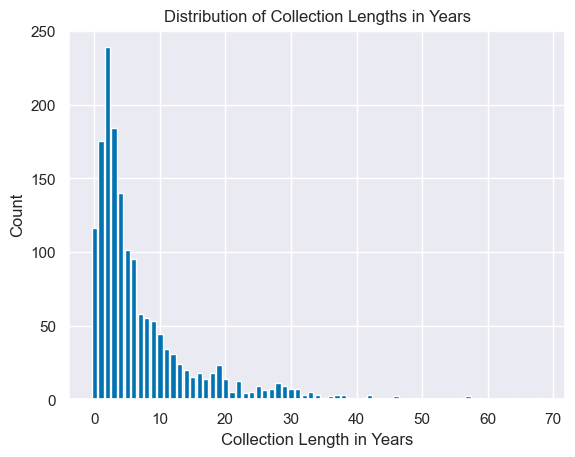

,collection_name,franchise_length_years
1574,Monster X Collection,41.0
1575,101 Dalmatians (Animated) Collection,42.0
1576,Dr. Mabuse Collection,42.0
1577,Goin' Down the Road Collection,42.0
1578,Coffin Joe Collection,44.0
1579,Lady and the Tramp Collection,46.0
1580,James Bond Collection,46.0
1581,Peter Pan Collection,49.0
1582,St. Trinian's Collection,56.0
1583,The Shadow Collection,57.0


In [68]:
# Count the number of collection of same length
franchise_data_df_counts = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_counts.columns = ['franchise_length_years', 'count']
# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['franchise_length_years'], franchise_data_df_counts['count'])
ax.set_xlabel('Collection Length in Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Collection Lengths in Years')
plt.show()

# Show the outliers for a length of 40 years and more
outliers = franchise_data_df[franchise_data_df['franchise_length_years'] >= 40]
outliers[['collection_name', 'franchise_length_years']]

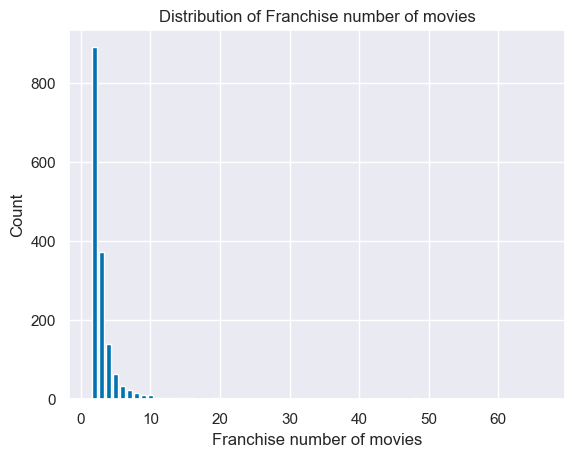

,collection_name,movie_count
461,Our Gang: The Roach/MGM silents (1927–1929),22
947,East Side Kids Collection,20
951,Our Gang: The Roach/Pathé silents (1922-1928),66
1094,The Three Mesquiteers Collection,51
1183,Charlie Chan (Sidney Toler) Collection,21
1320,The Bowery Boys Collection,48
1328,Beck Collection,25
1333,Our Gang: The MGM talkies (1929-1938),58
1438,Crayon Shin-chan Collection,20
1511,Tora-san Series,48


In [69]:
# Count the number of collection with the same number of movies
franchise_data_df_counts = franchise_data_df['movie_count'].value_counts().reset_index()
franchise_data_df_counts.columns = ['movie_count', 'count']
# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['movie_count'], franchise_data_df_counts['count'])
ax.set_xlabel('Franchise number of movies')
ax.set_ylabel('Count')
ax.set_title('Distribution of Franchise number of movies')
plt.show()

# Show the outliers for a number of movies of 20 and more
outliers = franchise_data_df[franchise_data_df['movie_count'] >= 20]
outliers[['collection_name', 'movie_count']]

We see that most of the franchise have 2 movies, which could be sequel of 2 movies but also be an original movie with a remake or an additional movie of a side story, to try to separate them, we try to normalize this length and number of movie distribution

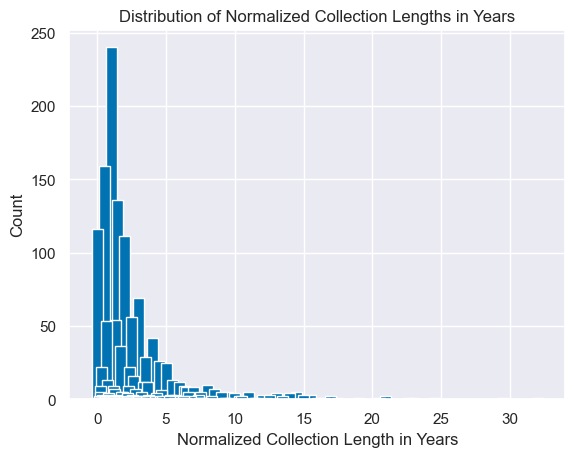

Outliers (Normalized Length >= 15 years):
                                 collection_name  franchise_length_normalized
1541                   The Odd Couple Collection                    15.000000
1543                    On Any Sunday Collection                    15.000000
1544                  Charlotte's Web Collection                    15.000000
1548                        The Birds Collection                    15.500000
1549                     Grey Gardens Collection                    15.500000
1551            The Snake King's Wife Collection                    15.500000
1554                The Irony of Fate Collection                    16.000000
1559                       Abel Gance's Napoleon                    16.500000
1561                    Quentin Crisp Collection                    17.000000
1563                               Oz Collection                    17.000000
1564                  The Jungle Book Collection                    17.500000
1574                  

In [70]:
# Normalize the length by the number of movies
franchise_data_df['franchise_length_normalized'] = franchise_data_df['franchise_length_years'] / franchise_data_df['movie_count']

# Count the number of collection with the same normalized length
franchise_data_df_counts = franchise_data_df['franchise_length_normalized'].value_counts().reset_index()
franchise_data_df_counts.columns = ['franchise_length_normalized', 'count']

# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['franchise_length_normalized'], franchise_data_df_counts['count'])
ax.set_xlabel('Normalized Collection Length in Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Normalized Collection Lengths in Years')
plt.show()

# Show the outliers for a normalized length of 15 years and more
print("Outliers (Normalized Length >= 15 years):")
print(franchise_data_df[franchise_data_df['franchise_length_normalized'] >= 15][['collection_name', 'franchise_length_normalized']])

# Show the 10 first where the normalized length under 5 years
print("\nFirst 10 (Normalized Length < 5 years):")
print(franchise_data_df[franchise_data_df['franchise_length_normalized'] < 5].head(10)[['collection_name', 'franchise_length_normalized']])

Now show the average vote score per collection for different normalized years values

In [71]:
# violin plot of the average vote by length in years with 8 bashes for 0,1,2,3,4,5,6 and more than 6 years
franchise_data_df['franchise_length_years_binned'] = pd.cut(franchise_data_df['franchise_length_years'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6+'])
# Calculate the mean and standard deviation of average_score for each franchise_length_years_binned
length_stats = franchise_data_df.groupby('franchise_length_years_binned')['average_score'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(length_stats['franchise_length_years_binned'], length_stats['mean'], yerr=length_stats['std'], fmt='-o', capsize=5)
ax.set_xlabel('Franchise Length in Years')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by Franchise Length in Years with Error Bars')
plt.show()

NameError: name 'np' is not defined

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_45487/200374398.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



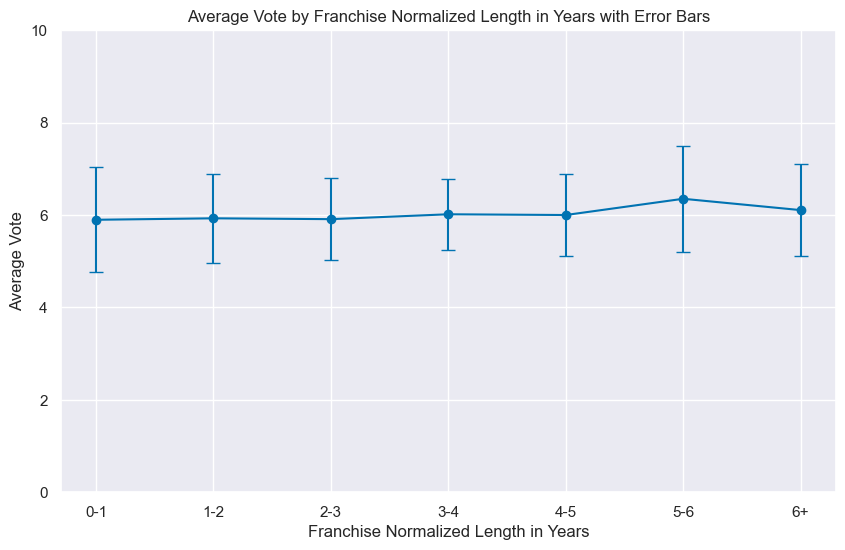

In [74]:
# violin plot of the average vote by length in years with 8 bashes for 0,1,2,3,4,5,6 and more than 6 years
franchise_data_df['franchise_normalized_length_years_binned'] = pd.cut(franchise_data_df['franchise_length_normalized'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6+'])
# Calculate the mean and standard deviation of average_score for each franchise_normalized_length_years_binned
length_stats = franchise_data_df.groupby('franchise_normalized_length_years_binned')['average_score'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(length_stats['franchise_normalized_length_years_binned'], length_stats['mean'], yerr=length_stats['std'], fmt='-o', capsize=5)
ax.set_xlabel('Franchise Normalized Length in Years')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by Franchise Normalized Length in Years with Error Bars')
ax.set_ylim(0, 10)
plt.show()

Now we can also investigate the score for each movie in a collection according to their order of release

In [75]:
# add a collmn with the numerotation of the movies in the collection by release date order
franchise_df['movie_order'] = franchise_df.groupby('collection_name')['Movie release date corrected'].rank(method='first')

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_45487/3741041517.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



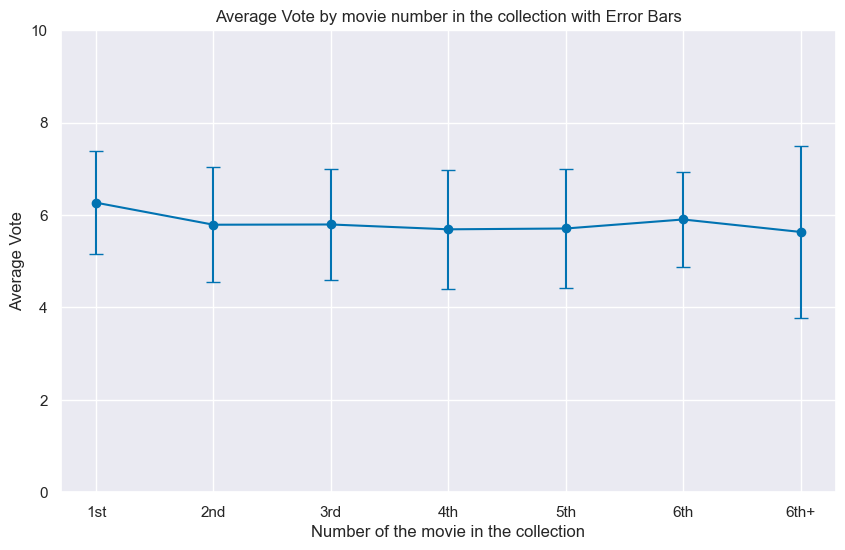

In [77]:
# violin plot of the average vote for the movie order with 8 bashes for 0,1,2,3,4,5,6 and more than 6th movie
franchise_df['movie_order_binned'] = pd.cut(franchise_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])
# Calculate the mean and standard deviation of vote_average for each movie_order_binned
order_stats = franchise_df.groupby('movie_order_binned')['vote_average'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(order_stats['movie_order_binned'], order_stats['mean'], yerr=order_stats['std'], fmt='-o', capsize=5)
ax.set_xlabel('Number of the movie in the collection')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by movie number in the collection with Error Bars')
ax.set_ylim(0, 10)
plt.show()

Now we can also compare the distribution of the vote score in franchise with a good overall review and ones with a worse overal review

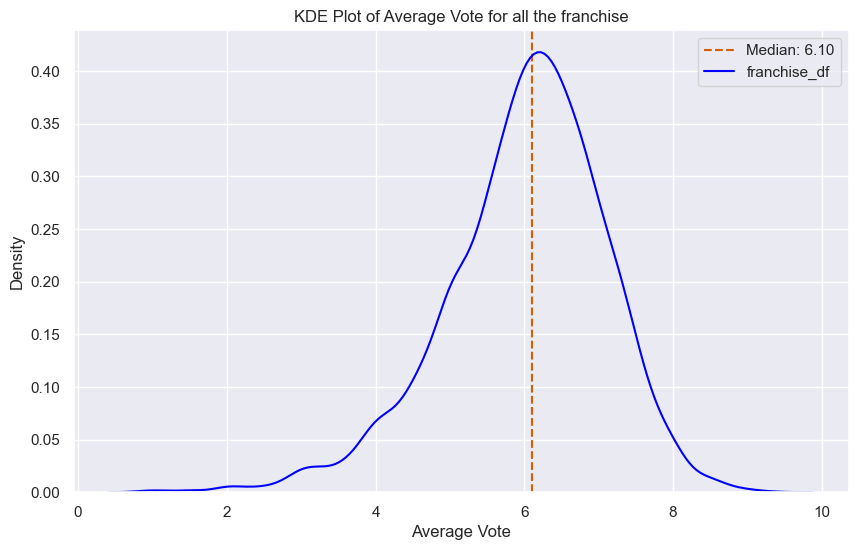

In [80]:
# kde plot of the average vote for all the franchise

fig, ax = plt.subplots(figsize=(10, 6))
average_vote = franchise_df[franchise_df['vote_average'] > 0]['vote_average'].median()
ax.axvline(average_vote, color='r', linestyle='--', label=f'Median: {average_vote:.2f}')
sns.kdeplot(franchise_df[franchise_df['vote_average'] > 0]['vote_average'].dropna(), ax=ax, label='franchise_df', color='blue')
ax.set_xlabel('Average Vote')
ax.set_ylabel('Density')
ax.set_title('KDE Plot of Average Vote for all the franchise')
ax.legend()
plt.show()


/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_45487/2205342380.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_45487/2205342380.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_45487/2205342380.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

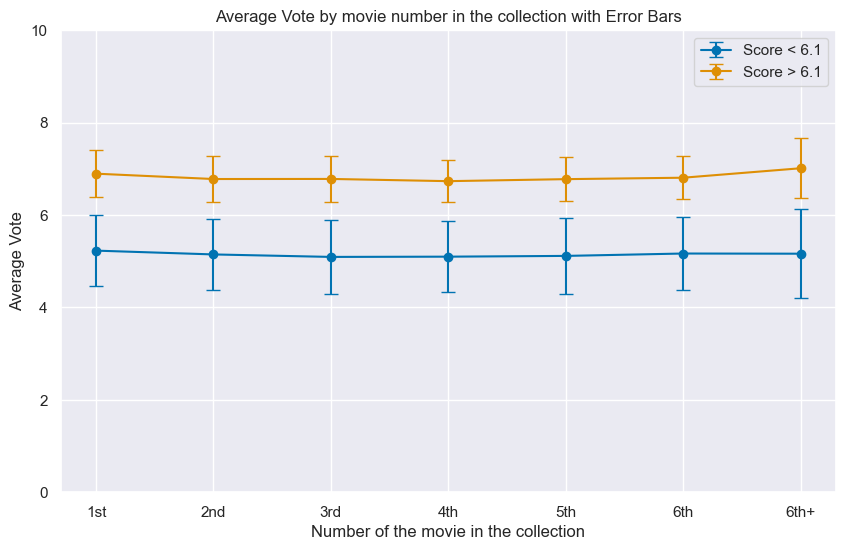

In [81]:
# Filter the data for collections with average scores less than 6.1
low_score_df = franchise_df[(franchise_df['vote_average'] < average_vote) & (franchise_df['vote_average'] > 0)]

# Filter the data for collections with average scores more than 6.1
high_score_df = franchise_df[franchise_df['vote_average'] > average_vote]

# Bin the movie order for both dataframes
low_score_df['movie_order_binned'] = pd.cut(low_score_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])
high_score_df['movie_order_binned'] = pd.cut(high_score_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])
# Calculate the mean and standard deviation of vote_average for each movie_order_binned
low_score_stats = low_score_df.groupby('movie_order_binned')['vote_average'].agg(['mean', 'std']).reset_index()
high_score_stats = high_score_df.groupby('movie_order_binned')['vote_average'].agg(['mean', 'std']).reset_index()
# Plot the line with error bars for both low and high score collections
fig, ax = plt.subplots(figsize=(10, 6))

# Plot low score collections
ax.errorbar(low_score_stats['movie_order_binned'], low_score_stats['mean'], yerr=low_score_stats['std'], fmt='-o', capsize=5, label='Score < 6.1')

# Plot high score collections
ax.errorbar(high_score_stats['movie_order_binned'], high_score_stats['mean'], yerr=high_score_stats['std'], fmt='-o', capsize=5, label='Score > 6.1')

ax.set_xlabel('Number of the movie in the collection')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by movie number in the collection with Error Bars')
ax.set_ylim(0, 10)
ax.legend()
plt.show()

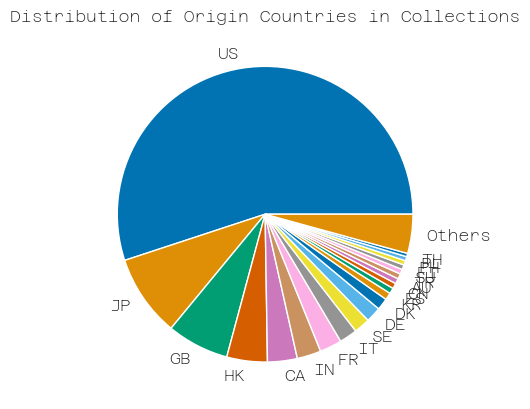

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
from pyfonts import load_font

#Origin Country

# Clean the categories and normalize the data
def clean_categories(category_string):
    # Remove brackets and quotes
    cleaned_category=category_string.replace("[","").replace("]","").replace("'","").split(", ")
    # Return category list
    return cleaned_category


# Initialize a defaultdict to hold category sums
country_sums = defaultdict(int)

# Iterate over the rows of the DataFrame
for _, row in franchise_df.iterrows():
    # Clean the categories
    origin_country_new = clean_categories(row['tmdb_origin_country'])
    # Increment the count for each category
    for country in origin_country_new:
        country_sums[country] += 1

# Convert the defaultdict to a DataFrame
country_count = pd.Series(country_sums)

# Sort the country_count Series by the number of movies for each country
country_count = country_count.sort_values(ascending=False)


# Only keep countries with more than 10 movies
others=country_count[country_count<20].sum()
country_count=country_count[country_count>=20]
country_count['Others']=others



font = load_font(
  font_url="https://github.com/google/fonts/blob/main/ofl/azeretmono/AzeretMono%5Bwght%5D.ttf?raw=true"
)


# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(country_count, labels=country_count.index, textprops={'fontproperties': font})
plt.title('Distribution of Origin Countries in Collections', fontproperties=font)
plt.show()



/var/folders/73/kcm6892d5ld1l9c9nhgd3y7m0000gn/T/ipykernel_13071/1709861789.py:47: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/73/kcm6892d5ld1l9c9nhgd3y7m0000gn/T/ipykernel_13071/1709861789.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = country_data.geometry.centroid.iloc[0]
/var/folders/73/kcm6892d5ld1l9c9nhgd3y7m0000gn/T/ipykernel_13071/1709861789.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = country_data.geometry.cent

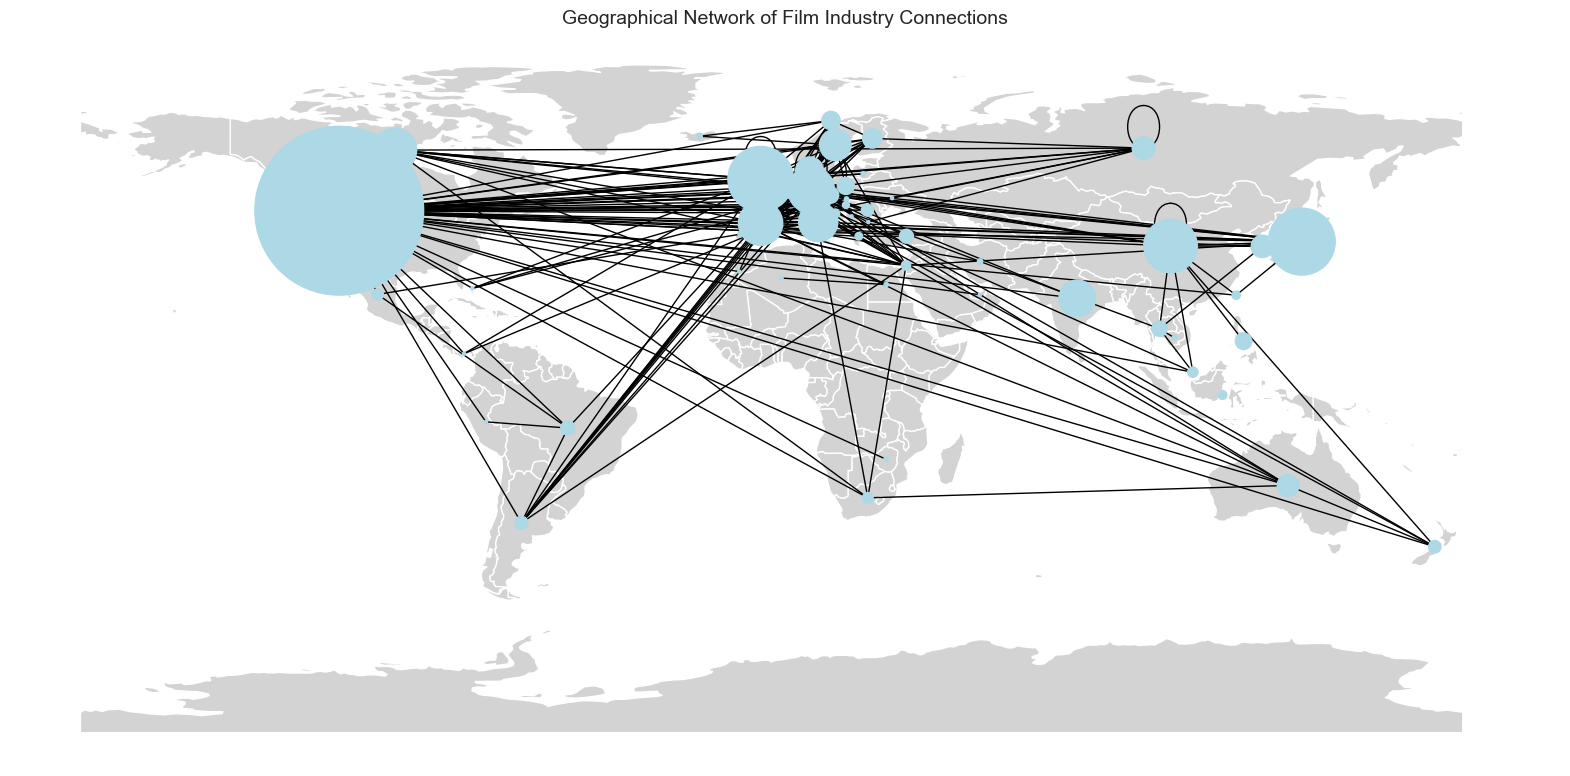

In [ ]:
# Network Analysis of the countries


### 1 - Cleaning the data   
# Initialize an empty list to store countries
cleaned_countries = []
country_counts = Counter()

# Iterate
for movie in franchise_df['Movie countries (Freebase ID:name tuples)']:
    if pd.notnull(movie):
        # Split the country by comma and strip any extra characters
        country_list = [movie.split(":")[1].strip().replace("\"", "").replace("}", "") for movie in movie.split(",") if ":" in movie]
        # Replace 'Hong Kong' with 'China'
        country_list = ['China' if country == 'Hong Kong' else country for country in country_list]
        country_list = ['Germany' if country == 'West Germany' else country for country in country_list]
        country_list = ['Germany' if country == 'Weimar Republic' else country for country in country_list]
        country_list = ['Germany' if country == 'German Democratic Republic' else country for country in country_list]
        country_list = ['Malaysia' if country == 'Singapore' else country for country in country_list]
        country_list = ['United Kingdom' if country == 'Kingdom of Great Britain' else country for country in country_list]
        country_list = ['United Kingdom' if country == 'England' else country for country in country_list]
        country_list = ['Croatia' if country == 'Yugoslavia' else country for country in country_list]
        country_list = ['Czechia' if country == 'Czech Republic' else country for country in country_list]
        country_list = ['Czechia' if country == 'Czechoslovakia' else country for country in country_list]
        country_list = ['Czechia' if country == 'Federal Republic of Yugoslavia' else country for country in country_list]
        country_list = ['Russia' if country == 'Soviet Union' else country for country in country_list]
        country_list = ['United Kingdom' if country == 'Scotland' else country for country in country_list]
        country_list = ['United Kingdom' if country == 'Wales' else country for country in country_list]
        country_list = ['United Kingdom' if country == 'Northern Ireland' else country for country in country_list]

        country_counts.update(country_list)
        cleaned_countries.append(country_list)

country_counts_df = pd.DataFrame.from_dict(country_counts, orient='index', columns=['counts']).reset_index()
country_counts_df.columns = ['country', 'counts']

### Create pairs of countries
country_pairs =[]

for countries in cleaned_countries:
    if len(countries) > 1:
        # Generate all possible combinations of countries
        country_pairs.extend(list(combinations(countries, 2)))

### Prepare the world map
# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Reproject the world map to a suitable projected CRS. The original data are for spherical coordinates and not planar.
#world_projected = world.to_crs(epsg=3857)  # Using Web Mercator projection (EPSG:3857)

# Make a list keeping only each country once
unique_countries = set(country for countries in cleaned_countries for country in countries)
unique_countries = list(unique_countries)


#Get the centroid of each country
country_coordinates={}

for country in unique_countries:
    country_data = world[world['name'] == country]
    if not country_data.empty:
        # Get the centroid of the country
        centroid = country_data.geometry.centroid.iloc[0]
        country_coordinates[country] = (centroid.x, centroid.y)


# Plot the graph 
# Initialize the graph
G = nx.Graph()

# Add nodes with geographic positions
for country, (x, y) in country_coordinates.items():
    G.add_node(country, pos=(x, y))

# Add edges
for pair in country_pairs:
    G.add_edge(pair[0], pair[1])

# Extract positions for networkx
pos = nx.get_node_attributes(G, 'pos')

# Plot the world map
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(ax=ax, color="lightgrey")

# Draw the network on top of the world map

# Get the size of each node based on the country count
node_sizes = [country_counts[country] * 5 for country in G.nodes()]

nx.draw(
    G, pos, ax=ax, with_labels=False, node_color='lightblue',
    node_size=node_sizes, font_size=8, font_weight='bold', edge_color='black'
)
# Set the title
plt.title("Geographical Network of Film Industry Connections", fontsize=14)
plt.show()

